In [327]:
%pip install torch torchvision matplotlib torchinfo torchviz

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(45)
np.random.seed(45)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [328]:
from torch.utils.data import Dataset
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [329]:
### TASK 1 ###

class TitanicDataset(Dataset): 
    # Create a dataset with a dataframe, a list of columns to onehotencode, a dict of categories
    # to name the new columns, a transformer, a boolean to decide if to transform or fit_transform, 
    # and a boolean flagging if this is the test set
    def __init__(self, DataFrame, Columns, categories, transformer, fit_transform=True, test=False):
        df = self.one_hot_encode(DataFrame, Columns, categories)
        df = self.scale(transformer, df, fit_transform)

        # Initialize tensors from dataframe

        # If it is the test set do not initialize labels
        if (test == True): 
            X = df.values
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = None
            self.feats = df.columns.tolist()
        else: 
            y = df["Survived"].values
            X = df.drop(columns=["Survived"]).values

            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.float32)
            self.feats = df.columns.tolist()

    # len and getitem are utilities for the dataloader 

    def __len__(self): 
        return len(self.X) 

    def __getitem__(self, idx): 
        if (self.y is not None):
            return self.X[idx], self.y[idx]

        return self.X[idx]           

    def one_hot_encode(self, DataFrame, Columns, categories): 
        df = DataFrame.copy() #create a copy to preserve original df

        column_names = []
        # loop through provided columns and convert indices to column names for use
        for i in Columns: 
            if (isinstance(i, int)): 
                column_names.append(df.columns[i])
            else: 
                column_names.append(i)

        # loop through all columns 
        for col in column_names: 
            # get all categories within the column 
            values = categories[col]

            # for all but the first category (ie. drop the first category)
            for val in values[1:]:
                new_col_name = f"{col}_{val}" #create new name

                # create a new column with the new title. Then we must assign each sample 
                # a value in this column. If the original categorical column's value for the sample is 
                # equal to the category we are building a column for this comparison will return
                # true, converted to 1, otherwise it will return false, converted to 0. 
                df[new_col_name] = (df[col] == val).astype(np.float32)
        
            df = df.drop(columns = [col]) #drop the original categorical column
    
        all_column_names = df.columns.tolist()

        #convert df to matrix and return 
        #numpy_mat = df.to_numpy(dtype=np.float32)
        #return numpy_mat, all_column_names

        return df
    
    def scale(self, transformer, DataFrame, fit_transform=True): 
        df = DataFrame.copy()

        # Only fit transform the training set 
        if(fit_transform):
            data = transformer.fit_transform(df)
        else:
            data = transformer.transform(df)

        # Add normalized data to dataframe
        for index, column in enumerate(transformer.get_feature_names_out()):
            df[column] = data[:,index]
        
        # Return
        return df
        


In [330]:
# Reading in data
train_df_ori = pd.read_csv('train.csv')
test_df_ori = pd.read_csv('test.csv')

# Saving passenger id's for kaggle submission
passenger_ids = test_df_ori["PassengerId"]

train_df = train_df_ori.copy()
test_df = test_df_ori.copy()


In [331]:
irrelevant_feats = ['PassengerId', 'Name', 'Cabin', 'Ticket'] 
train_df.drop(irrelevant_feats, axis=1, inplace=True)
test_df.drop(irrelevant_feats, axis=1, inplace=True)

In [332]:
# Imputing - This step will fill in blank or missing values in the dataset

numerical_feats = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
categorical_feats = ["Sex", "Embarked"]

# We will replace missing numerical values with the median for that feature
num_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
# We will replace missing categorical values with the mode for that feature 
cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# For every column other than "Survived", search for missing values
# and replace them using the corresponding imputer 
for column in train_df.columns[1:]: 
    if (column in numerical_feats): 
        fill = num_imputer.fit_transform(train_df[column].values.reshape(-1,1))
        train_df[column] = fill.ravel()
        fill = num_imputer.transform(test_df[column].values.reshape(-1,1))
        test_df[column] = fill.ravel()
    else: 
        fill = cat_imputer.fit_transform(train_df[column].values.reshape(-1,1))
        train_df[column] = fill.ravel()
        fill = cat_imputer.transform(test_df[column].values.reshape(-1,1))
        test_df[column] = fill.ravel()

In [333]:
# Using ColumnTransformer to apply specific normalization to each column in our data
norm_scaler = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), ['Pclass', 'Parch']),  
        ('standard', StandardScaler(), ['Age', 'SibSp', 'Fare'])
    ], verbose_feature_names_out=False
)

In [334]:
df_train, df_val = train_test_split(train_df, test_size=0.15, stratify = train_df['Survived'], random_state=45)

In [335]:
categorical_feats = ["Sex", "Embarked"]

# When using the custom dataset class we need to create a dictionary ordering 
# the categories for onehotencoding, otherwise the test, val, and training sets
# may end up with different columns
categories = {}
for col in ['Sex', 'Embarked']:
    categories[col] = train_df[col].unique().tolist()

train_dataset = TitanicDataset(df_train, categorical_feats, categories, norm_scaler, True, False)
val_dataset = TitanicDataset(df_val, categorical_feats, categories, norm_scaler, False, False)
test_dataset = TitanicDataset(test_df, categorical_feats, categories, norm_scaler, False, True)

In [336]:
import torch.nn as nn
import torch.optim

In [337]:
### TASK 2 ###

class MLP_Network(nn.Module): 
    # Neural netowrk class, it takes in the size of the input layer, size of the first hidden layer, 
    # size of the output layer, the number of hhidden layers, the learnign rate, and a regularization term
    def __init__(self, input_size, hidden_size, num_classes, network_depth, learning_rate, regularization): 

        # don't ask me what this means it's in Dr. Santos's code and everything explodes if i take it out 
        super(MLP_Network, self).__init__()

        self.model = nn.Sequential() # all layers we all will be performed in sequential order 

        in_size = input_size
        out_size = hidden_size

        # build each layer sequentially, halving layer size each iteration 
        for layer in range(network_depth): 
            self.model.add_module(f"layer_{layer}", nn.Linear(in_size, out_size))
            self.model.add_module(f"activation_{layer}", nn.ReLU())

            in_size = out_size
            out_size = max(1, out_size//2)

        # add final output layer
        self.model.add_module(f"output_layer", nn.Linear(in_size, num_classes))
        #self.model.add_module(f"output_activation", nn.ReLU())

        # set loss and optimzer variables 
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=learning_rate, weight_decay = regularization)

    # forward performs one forward pass through the whole model 
    def forward(self, x): 
        return self.model(x)    


In [338]:
model = MLP_Network(input_size=8, hidden_size=16, num_classes=2, network_depth=3, learning_rate=0.1, regularization=0.0)

model.to(device)

print(model)

MLP_Network(
  (model): Sequential(
    (layer_0): Linear(in_features=8, out_features=16, bias=True)
    (activation_0): ReLU()
    (layer_1): Linear(in_features=16, out_features=8, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=8, out_features=4, bias=True)
    (activation_2): ReLU()
    (output_layer): Linear(in_features=4, out_features=2, bias=True)
  )
  (loss): CrossEntropyLoss()
)


In [339]:
# define loaders 
train_loader = DataLoader(
    # these variable primarily affect efficiency at fetching data
    train_dataset,
    batch_size=64,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
)

In [340]:
# training loop 
# takes in a defined model, a training and validation loader, a number of epochs, and a boolean flag for progress printing 

def train(model, train_loader, val_loader, num_epochs, show=False): 
    final_val = 0.0

    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs): 
        model.train()

        # We will track loss and accuracy for each epoch 
        running_loss = 0.0
        running_corrects = 0

        # each epoch is broken into batches of 64 
        for inputs, labels in train_loader: 
            inputs, labels = inputs.to(device), labels.long().to(device)

            # zero our gradients, perform a forward pass, calculate loss, a backward pass, then optimze 
            model.optimizer.zero_grad()
            outputs = model(inputs)
            loss = model.loss(outputs, labels)
            loss.backward()
            model.optimizer.step()

            # here we make predictions to track accuracy 
            _, preds = torch.max(outputs,1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum().item()

        # track epoch training loss 
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)

        train_losses.append(epoch_loss)

        if(show):
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss} | Accuracy: {epoch_acc}")

        # Validation loop 
        # this validation loop is almost identical to the training loop 
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad(): 
            for inputs, labels in val_loader: 
                inputs, labels = inputs.to(device), labels.long().to(device)
                
                outputs = model(inputs)
                loss = model.loss(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += (preds == labels).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects / len(val_loader.dataset)
        final_val = val_acc

        val_losses.append(val_loss)

        if(show):
            print(f"Validation Loss: {val_loss} | Accuracy: {val_acc}")
    
    return final_val, train_losses, val_losses

In [341]:
# eval is designed to take in a trained model and a testing loader 
def eval(model, test_loader): 
    model.eval()
    predictions = []

    with torch.no_grad(): # do not use gradients when testing 
        for inputs in test_loader: 
            inputs = inputs.to(device)
            outputs = model(inputs)

            # make a prediction, convert it to numpy, and track it for submission 
            _, prediction = torch.max(outputs, 1)
            prediction = prediction.numpy()

            for sample in prediction: 
                predictions.append(sample)
            

    return np.array(predictions)

In [342]:
acc, train_losses, val_losses = train(model, train_loader, val_loader, 100)

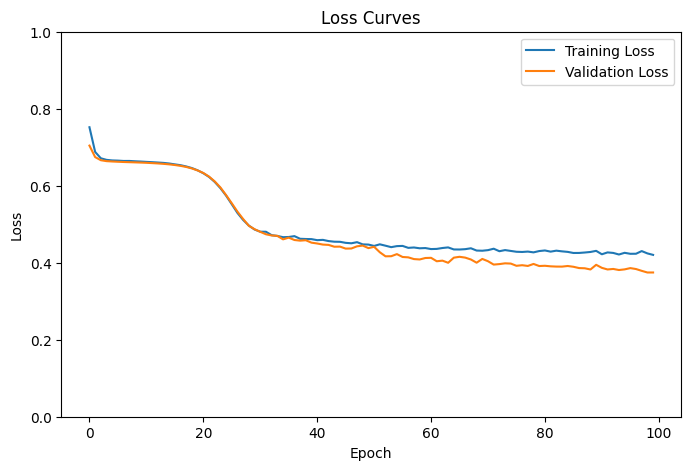

In [343]:
import matplotlib.pyplot as plt

# Plotting loss curve 
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.title('Loss Curves')
plt.legend()
plt.show()

In [344]:
import itertools
from collections import namedtuple

In [345]:
# HYPERPARAMETER SEARCH 

# here are our 36 combinations of parameters 
param_distributions = {
    'depth': [3, 5], 
    'layer_size': [16, 32], 
    'lr': [.001, .01, .1], 
    'reg': [.00, 1e-4, 1e-3]
}

results = []

# For every combination of our parameters 
for depth, layer_size, lr, reg in itertools.product(
        param_distributions['depth'],
        param_distributions['layer_size'],
        param_distributions['lr'],
        param_distributions['reg']): 
    
    # define and train a model with current combination 
    model = MLP_Network(8, layer_size, 2, depth, lr, reg)
    model.to(device)

    acc = train(model, train_loader, val_loader, 50)

    # we will stoe a tuple for every combination containing accuracy and each parameter value 
    result = namedtuple('result', ['acc', 'depth', 'layer_size', 'lr', 'reg'])

    trial = result(acc, depth, layer_size, lr, reg)
    results.append(trial)    

# sort the results of the grid search by validation accuracy 
results.sort(key=lambda x: x[0])
for trial in results: 
    print(f"Parameters depth:{trial.depth} layer_size:{trial.layer_size} lr:{trial.lr} reg:{trial.reg} gave accuracy of: {trial.acc[0]}")

Parameters depth:5 layer_size:32 lr:0.001 reg:0.0 gave accuracy of: 0.3805970149253731
Parameters depth:5 layer_size:32 lr:0.001 reg:0.0001 gave accuracy of: 0.3805970149253731
Parameters depth:3 layer_size:16 lr:0.001 reg:0.0 gave accuracy of: 0.3805970149253731
Parameters depth:3 layer_size:16 lr:0.001 reg:0.001 gave accuracy of: 0.3880597014925373
Parameters depth:3 layer_size:16 lr:0.01 reg:0.0 gave accuracy of: 0.6194029850746269
Parameters depth:3 layer_size:32 lr:0.01 reg:0.0 gave accuracy of: 0.6194029850746269
Parameters depth:5 layer_size:16 lr:0.1 reg:0.001 gave accuracy of: 0.6194029850746269
Parameters depth:3 layer_size:32 lr:0.001 reg:0.0001 gave accuracy of: 0.6194029850746269
Parameters depth:3 layer_size:32 lr:0.001 reg:0.0 gave accuracy of: 0.6194029850746269
Parameters depth:3 layer_size:16 lr:0.001 reg:0.0001 gave accuracy of: 0.6194029850746269
Parameters depth:5 layer_size:32 lr:0.01 reg:0.0 gave accuracy of: 0.6194029850746269
Parameters depth:3 layer_size:32 lr

In [346]:
from sklearn.decomposition import PCA

In [347]:
### TASK 3 ###

X_train = train_dataset.X.numpy()
X_val = val_dataset.X.numpy()
X_test = test_dataset.X.numpy()

# Fitting PCA on X_train
pca = PCA()
pca.fit(X_train)

ratio = pca.explained_variance_ratio_
cumulative_ratio = np.cumsum(ratio)

print(cumulative_ratio)

[0.34851545 0.66777194 0.8510151  0.91128266 0.94938165 0.9765948
 0.9950384  1.        ]


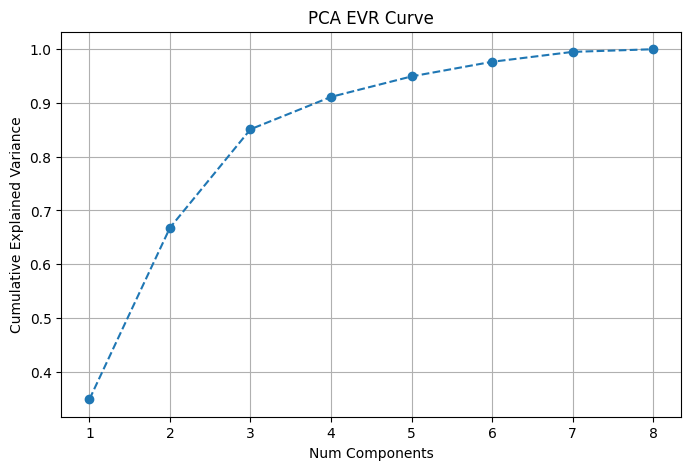

In [348]:
# Printing PCA EVR

plt.figure(figsize=(8,5))
plt.plot(range(1, len(ratio)+1), cumulative_ratio, marker='o', linestyle='--')
plt.title('PCA EVR Curve')
plt.xlabel('Num Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [349]:
n_components = 4 # 4 components gives 91.1% variance

pca = PCA(n_components=n_components)

# Now we transform our datasets, fit transform on train and just transform on validation and test 
X_train_pca = pca.fit_transform(X_train) 
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [350]:
# This version of the Titanic Dataset accepts two tensors instead
# of a pandas dataframe. Because the PCA data has already been processed
# we remove the scaling and one hot encoding functions 
class TitanicPCADataset(Dataset): 
    def __init__(self, X, y, test=False): 
        if (test == True): 
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = None
        else: 
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self): 
        return len(self.X)
    
    def __getitem__(self, idx): 
        if (self.y is not None):
            return self.X[idx], self.y[idx]

        return self.X[idx] 

In [351]:
# PCA data
train_dataset_pca = TitanicPCADataset(X_train_pca, train_dataset.y, False)
val_dataset_pca = TitanicPCADataset(X_val_pca, val_dataset.y, False)
test_dataset_pca = TitanicPCADataset(X_test_pca, test_dataset.y, True)


C:\Users\zebul\AppData\Local\Temp\ipykernel_3944\2897537228.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


In [352]:
train_loader_pca = DataLoader(
    # these variable primarily affect efficiency at fetching data
    train_dataset_pca,
    batch_size=64,
    shuffle=True,
)

val_loader_pca = DataLoader(
    val_dataset_pca,
    batch_size=64,
    shuffle=False,
)

test_loader_pca = DataLoader(
    test_dataset_pca,
    batch_size=64,
    shuffle=False,
)

In [353]:
# PCA MLP model 

model_nn_pca = MLP_Network(input_size=4, hidden_size=16, num_classes=2, network_depth=3, learning_rate=0.1, regularization=0.0)

model_nn_pca.to(device)

print(model_nn_pca)

MLP_Network(
  (model): Sequential(
    (layer_0): Linear(in_features=4, out_features=16, bias=True)
    (activation_0): ReLU()
    (layer_1): Linear(in_features=16, out_features=8, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=8, out_features=4, bias=True)
    (activation_2): ReLU()
    (output_layer): Linear(in_features=4, out_features=2, bias=True)
  )
  (loss): CrossEntropyLoss()
)


In [354]:
acc, train_losses, val_losses = train(model_nn_pca, train_loader_pca, val_loader_pca, 50)

In [355]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix

In [356]:
# Logistic regression model for testing 

log_classifier = LogisticRegression(max_iter=1000, random_state=45)
log_classifier.fit(train_dataset_pca.X, train_dataset_pca.y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,45
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [357]:
# Predictions from SKlearn model
y_val_pred = log_classifier.predict(val_dataset_pca.X)
y_val_probs = log_classifier.predict_proba(val_dataset_pca.X)[:, 1]  # probability of "Survived" 

# Metrics
acc = accuracy_score(val_dataset_pca.y, y_val_pred)
loss = log_loss(val_dataset_pca.y, y_val_probs)
cm = confusion_matrix(val_dataset_pca.y, y_val_pred)

print("Validation Accuracy:", acc)
print("Validation Log Loss (Binary Cross Entropy):", loss)
print("Confusion Matrix:\n", cm)

Validation Accuracy: 0.8059701492537313
Validation Log Loss (Binary Cross Entropy): 0.47358998692708226
Confusion Matrix:
 [[77  6]
 [20 31]]


In [358]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [359]:
# Start of random forest model 

pipe = Pipeline([
    ('model', RandomForestClassifier(random_state=42))
])

# param_distributions contains all of the options for each parameter we will experiment with 
param_distributions = {
    'model__n_estimators': [10, 50, 100, 200, 400, 800],
    'model__max_depth': [None, 5, 10, 20, 40],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False]
}

In [360]:
# randomized search will allow us to try all permutations of these parameters 
search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=20,              # number of random combinations to try
    cv=5,                   # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(train_dataset_pca.X, train_dataset_pca.y)

# saving the best performing model for future use 
best_rf = search.best_estimator_

print("Best parameters:", search.best_params_)
print("Best cross-validation accuracy:", search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'model__n_estimators': 800, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': 5, 'model__bootstrap': True}
Best cross-validation accuracy: 0.8057772743116068


In [361]:
X_test = test_dataset_pca.X

In [362]:
# Making predictions on PCA data using random forest 

y_test_pred_rf = best_rf.predict(X_test)

# Build submission DataFrame
submission = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": y_test_pred_rf.astype(int)
})

submission.to_csv("best_rf_submission.csv", index=False)


In [363]:
# Making predictions on PCA data using logistic regression

y_test_pred_logreg = log_classifier.predict(X_test)

submission = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": y_test_pred_logreg.astype(int)
})

submission.to_csv("best_logreg_submission.csv", index=False)

In [364]:
# Making predictions on PCA data using MLP 

y_test_pred_mlp = eval(model_nn_pca, test_loader_pca)

submission = pd.DataFrame({
     "PassengerId": passenger_ids,
     "Survived": y_test_pred_mlp.astype(int)
 })

submission.to_csv("best_mlp_submission.csv", index=False)